In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('C:\Users\meuli\Desktop\ML\EECE5644\FinalProject'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

Text(0.5, 1.0, 'Class Imbalance')

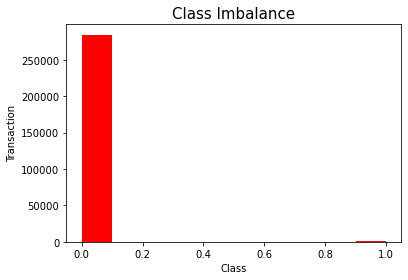

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('creditcard.csv')
plt.hist(data['Class'], color='red')
plt.xlabel('Class')
plt.ylabel('Transaction')
plt.title('Class Imbalance', fontsize=15)

In [17]:
pc_fraud = len(data.loc[data['Class'] == 1].values)/len(data.loc[data['Class'] == 0].values)
print(pc_fraud*100)
print(data.head())

0.17304750013189596
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26 

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

# Original dataset
x = data.drop('Class', axis=1).values
y = data['Class'].values
scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.transform(x)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

print('Sampled train dataset shape %s' % Counter(ytrain))
print('Sampled validation dataset shape %s' % Counter(ytest))

Sampled train dataset shape Counter({0: 227454, 1: 391})
Sampled validation dataset shape Counter({0: 56861, 1: 101})


In [19]:
import torch

bs =100

#creating torch dataset and loader using original dataset. 
#to use resampled dataset, replace ex. xtrain with xtrain_over etc.
train_ds = torch.utils.data.TensorDataset(torch.tensor(xtrain).float(), torch.tensor(ytrain).float())
valid_ds = torch.utils.data.TensorDataset(torch.tensor(xtest).float(), torch.tensor(ytest).float())

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bs)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=bs)

In [20]:
#network class 2-hidden layer model
class Classifier(torch.nn.Module):
    def __init__(self, n_input=10, n_hidden = 20, n_output = 1,drop_prob=0.5):
        super().__init__()
        self.extractor1 = torch.nn.Linear(n_input, n_hidden)
        self.extractor2 = torch.nn.Linear(n_hidden, n_hidden)
        self.relu = torch.nn.ReLU()
        self.drop_out = torch.nn.Dropout(drop_prob)
        self.classifier = torch.nn.Linear(n_hidden, n_output)

    def forward(self, xb):
        x = self.relu(self.extractor1(xb))
        x = self.relu(self.extractor2(x))
        x = self.drop_out(x)
        return self.classifier(x).squeeze()

In [21]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [22]:
#training the network
def train(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [23]:
#network setting
n_input = xtrain.shape[1]
n_output = 1
n_hidden = 15

model = Classifier(n_input=n_input,n_hidden=n_hidden,n_output=n_output,drop_prob=0.2)

lr = 0.001

#for orignal dataset, I use pos_weight.
pos_weight = torch.tensor([5])
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

n_epoch = 200

In [24]:
train(n_epoch,model,loss_func,opt,train_dl,valid_dl)
model.eval()

0 0.04896211961581128
1 0.04806335966745101
2 0.047329842957430375
3 0.04660354073225679
4 0.04564841210638805
5 0.04462816001065404
6 0.043337437418335886
7 0.04160038221370192
8 0.03946779663949375
9 0.03669009401639322
10 0.03389384188184374
11 0.031063886416084468
12 0.028466187282816757
13 0.025887499222991217
14 0.02372430297226121
15 0.021559454385702757
16 0.01969615969089509
17 0.018190110755482256
18 0.0167992748046242
19 0.015705560342496056
20 0.01503860175501009
21 0.014134874126183552
22 0.013548916961149286
23 0.013066655243010046
24 0.012687963161248076
25 0.012461640384000612
26 0.01231706821192549
27 0.011986736058316903
28 0.011757101806128269
29 0.011897928800700966
30 0.011627498839256638
31 0.011483435921831495
32 0.011448667220721232
33 0.011336398445839821
34 0.011283340531473831
35 0.011187666358337777
36 0.011143308848668829
37 0.011040191258071031
38 0.011048835583192813
39 0.011022652279821153
40 0.011026709553654038
41 0.010904539788874257
42 0.010920759771

Classifier(
  (extractor1): Linear(in_features=30, out_features=15, bias=True)
  (extractor2): Linear(in_features=15, out_features=15, bias=True)
  (relu): ReLU()
  (drop_out): Dropout(p=0.2, inplace=False)
  (classifier): Linear(in_features=15, out_features=1, bias=True)
)

In [25]:
from sklearn import metrics
ypred = model(torch.tensor(xtest).float()).detach().numpy()

ypred [ypred>=0.5] =1.0
ypred [ypred<0.5] =0.0
print('Confusion matrix: {}'. format(metrics.confusion_matrix(ytest, ypred)))
print('AUPRC score: {}'. format(metrics.average_precision_score(ytest, ypred)))
print('AUROC score: {}'.format(metrics.roc_auc_score(ytest, ypred)))
print('Accuracy score: {}'.format(metrics.accuracy_score(ytest, ypred)))
print(metrics.classification_report(ytest, ypred))

Confusion matrix: [[56844    17]
 [   19    82]]
AUPRC score: 0.6728008024284751
AUROC score: 0.9057911067130702
Accuracy score: 0.9993679997191109
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.83      0.81      0.82       101

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

